# Fraud Detection Model - Toy Example

This notebook demonstrates a comprehensive fraud detection system as described in our data science exercise. We'll build a multi-layered approach combining supervised learning with unsupervised anomaly detection.

## Overview
- Generate synthetic payment transaction data with realistic fraud patterns
- Handle extreme class imbalance with advanced techniques (SMOTE-NC, cost-sensitive learning)
- Train a Gradient-Boosted Tree model (XGBoost) for supervised detection
- Build unsupervised models (Isolation Forest, Deep Autoencoder) for novel fraud detection
- Implement real-time scoring pipeline with explainability (SHAP)
- Evaluate with business-relevant metrics (AUPRC, cost-weighted F1, precision@recall)

## Key Concepts Demonstrated
- **Multi-layered Detection**: Supervised + Unsupervised models working together
- **Class Imbalance**: Advanced sampling and cost-sensitive techniques
- **Feature Engineering**: Velocity features, behavioral profiles, network analysis
- **Explainability**: SHAP for model interpretability and compliance
- **Business Metrics**: Cost-aware evaluation aligned with business impact


In [1]:
# Import required libraries
import pandas as pd
import numpy as np
from faker import Faker
import xgboost as xgb
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, auc
from sklearn.metrics import average_precision_score, f1_score, precision_score, recall_score
from imblearn.over_sampling import SMOTENC
import matplotlib.pyplot as plt
import seaborn as sns
import shap
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
np.random.seed(42)
fake = Faker()
Faker.seed(42)

print("Libraries imported successfully!")

Libraries imported successfully!


## 1. Generate Synthetic Transaction Data

We'll create realistic payment transaction data with various fraud patterns that mirror real-world scenarios.


In [2]:
# Generate synthetic customer profiles
def generate_customers(n_customers=10000):
    customers = []
    
    for i in range(n_customers):
        # Customer demographics
        age = max(18, min(80, int(np.random.normal(40, 15))))
        account_age_days = max(1, int(np.random.exponential(365)))  # Newer accounts are riskier
        
        customer = {
            'cust_id': f'CUST_{i:07d}',
            'age': age,
            'account_age_days': account_age_days,
            'credit_score': max(300, min(850, int(np.random.normal(650, 100)))),
            'country': np.random.choice(['US', 'CA', 'UK', 'DE', 'FR', 'AU', 'Other'], 
                                     p=[0.4, 0.1, 0.1, 0.1, 0.1, 0.05, 0.15]),
            'risk_profile': np.random.choice(['low', 'medium', 'high'], p=[0.7, 0.25, 0.05])
        }
        customers.append(customer)
    
    return pd.DataFrame(customers)

# Generate synthetic transactions with realistic fraud patterns
def generate_transactions(customers_df, n_transactions=100000, fraud_rate=0.001):
    transactions = []
    start_date = datetime.now() - timedelta(days=90)
    
    # Merchant categories with different risk levels
    merchant_categories = {
        'grocery': {'risk': 0.0001, 'avg_amount': 50},
        'gas_station': {'risk': 0.0002, 'avg_amount': 40},
        'restaurant': {'risk': 0.0003, 'avg_amount': 35},
        'retail': {'risk': 0.0005, 'avg_amount': 80},
        'online': {'risk': 0.002, 'avg_amount': 120},
        'atm': {'risk': 0.001, 'avg_amount': 200},
        'gambling': {'risk': 0.01, 'avg_amount': 300},
        'crypto': {'risk': 0.015, 'avg_amount': 500}
    }
    
    # Device fingerprints (some will be shared by fraudsters)
    device_pool = [f'device_{i:06d}' for i in range(n_transactions // 20)]
    fraudulent_devices = np.random.choice(device_pool, size=50, replace=False)  # Known bad devices
    
    for i in range(n_transactions):
        # Select random customer
        customer = customers_df.sample(1).iloc[0]
        
        # Generate timestamp (more transactions during business hours)
        days_ago = np.random.exponential(10)  # Recent transactions more likely
        # Hour probabilities: quiet hours (0-5), morning rush (6-7), business hours (8-17), evening (18-21), late night (22-23)
        hour_probs = [0.01]*6 + [0.02]*2 + [0.08]*10 + [0.05]*4 + [0.02]*2
        hour_probs = np.array(hour_probs) / np.sum(hour_probs)  # Normalize to sum to 1
        hour = int(np.random.choice(range(24), p=hour_probs))  # Convert to Python int
        timestamp = start_date + timedelta(days=days_ago, hours=hour, 
                                         minutes=np.random.randint(0, 60))
        
        # Select merchant category
        mcc_category = np.random.choice(list(merchant_categories.keys()),
                                      p=[0.25, 0.15, 0.2, 0.2, 0.1, 0.05, 0.03, 0.02])
        mcc_info = merchant_categories[mcc_category]
        
        # Generate transaction amount
        base_amount = np.random.lognormal(np.log(mcc_info['avg_amount']), 0.8)
        amount = max(1, round(base_amount, 2))
        
        # Determine if transaction is fraudulent
        base_fraud_prob = mcc_info['risk']
        
        # Risk factors that increase fraud probability
        risk_multiplier = 1.0
        if customer['account_age_days'] < 30:
            risk_multiplier *= 3  # New accounts
        if customer['credit_score'] < 500:
            risk_multiplier *= 2  # Poor credit
        if customer['risk_profile'] == 'high':
            risk_multiplier *= 4
        if amount > 1000:
            risk_multiplier *= 2  # High amounts
        if hour < 6 or hour > 22:
            risk_multiplier *= 1.5  # Unusual hours
        
        fraud_prob = min(0.1, base_fraud_prob * risk_multiplier)
        is_fraud = np.random.random() < fraud_prob
        
        # Generate device fingerprint
        if is_fraud and np.random.random() < 0.3:
            # Fraudsters sometimes use known bad devices
            device_fingerprint = np.random.choice(fraudulent_devices)
        else:
            device_fingerprint = np.random.choice(device_pool)
        
        # Generate IP geolocation
        if is_fraud and np.random.random() < 0.4:
            # Fraud often comes from different countries
            geo_country = np.random.choice(['XX', 'RU', 'CN', 'NG', 'RO'])
        else:
            geo_country = customer['country']
        
        # Fraud patterns: velocity and amounts
        if is_fraud:
            # Fraudsters often make multiple rapid transactions
            if np.random.random() < 0.6:
                amount *= np.random.uniform(2, 5)  # Larger amounts
        
        transaction = {
            'txn_id': f'TXN_{i:08d}',
            'cust_id': customer['cust_id'],
            'timestamp': timestamp,
            'amount': round(amount, 2),
            'mcc_category': mcc_category,
            'device_fingerprint': device_fingerprint,
            'geo_country': geo_country,
            'hour_of_day': hour,
            'is_weekend': timestamp.weekday() >= 5,
            'is_fraud': is_fraud
        }
        transactions.append(transaction)
    
    df = pd.DataFrame(transactions)
    df = df.sort_values('timestamp').reset_index(drop=True)
    
    return df

# Generate the datasets
print("Generating customer profiles...")
customers_df = generate_customers(10000)

print("Generating transactions...")
transactions_df = generate_transactions(customers_df, 100000, fraud_rate=0.001)

print(f"Generated {len(customers_df)} customers and {len(transactions_df)} transactions")
print(f"Fraud rate: {transactions_df['is_fraud'].mean():.4f} ({transactions_df['is_fraud'].sum()} fraudulent transactions)")

# Display sample data
print("\nSample transactions:")
print(transactions_df.head())


Generating customer profiles...
Generating transactions...
Generated 10000 customers and 100000 transactions
Fraud rate: 0.0018 (182 fraudulent transactions)

Sample transactions:
         txn_id       cust_id                  timestamp  amount mcc_category  \
0  TXN_00087780  CUST_0007935 2025-03-23 08:05:42.782474   34.50       retail   
1  TXN_00024866  CUST_0007195 2025-03-23 08:12:52.723846  104.10   restaurant   
2  TXN_00046959  CUST_0001346 2025-03-23 08:17:23.344235   21.78      grocery   
3  TXN_00041667  CUST_0003400 2025-03-23 08:34:55.051325  103.80       online   
4  TXN_00033485  CUST_0002573 2025-03-23 09:19:13.210836   42.85   restaurant   

  device_fingerprint geo_country  hour_of_day  is_weekend  is_fraud  
0      device_000334          US            0        True     False  
1      device_004180          FR            0        True     False  
2      device_001749          US            0        True     False  
3      device_001439          CA            0        

## 2. Feature Engineering

Create sophisticated features including velocity metrics, behavioral profiles, and network analysis.


In [7]:
# Feature engineering for fraud detection
def create_fraud_features(transactions_df, customers_df):
    """Create comprehensive features for fraud detection"""
    
    # Merge with customer data
    data = transactions_df.merge(customers_df, on='cust_id', how='left')
    
    # Sort by customer and timestamp for window calculations
    data = data.sort_values(['cust_id', 'timestamp']).reset_index(drop=True)
    
    print("Creating velocity features...")
    
    # Velocity features (rolling windows) - using correct pandas syntax
    for window_hours in [1, 6, 24, 168]:  # 1h, 6h, 1d, 1w
        window_str = f'{window_hours}H'  # Pandas frequency string
        
        # Set timestamp as index temporarily for rolling operations
        data_indexed = data.set_index('timestamp')
        
        # Count of transactions in window (use count() instead of size())
        data[f'txn_count_{window_hours}h'] = (
            data_indexed.groupby('cust_id')['amount']  # Use a column for count
            .rolling(window_str, closed='both')
            .count()
            .reset_index(level=0, drop=True)
            .reindex(data.index)
            .fillna(1)
        )
        
        # Sum of amounts in window  
        data[f'amount_sum_{window_hours}h'] = (
            data_indexed.groupby('cust_id')['amount']
            .rolling(window_str, closed='both')
            .sum()
            .reset_index(level=0, drop=True)
            .reindex(data.index)
            .fillna(data['amount'])
        )
        
        # Skip unique merchants for now - this requires more complex handling of categorical data
        # We'll add simpler categorical features later
        pass
    
    print("Creating behavioral features...")
    
    # Customer historical behavior (up to current transaction)
    data['customer_avg_amount'] = (
        data.groupby('cust_id')['amount']
        .expanding()
        .mean()
        .reset_index(level=0, drop=True)
    )
    
    data['customer_std_amount'] = (
        data.groupby('cust_id')['amount']
        .expanding()
        .std()
        .reset_index(level=0, drop=True)
        .fillna(0)
    )
    
    # Z-score of current amount vs historical
    data['amount_zscore'] = np.where(
        data['customer_std_amount'] > 0,
        (data['amount'] - data['customer_avg_amount']) / data['customer_std_amount'],
        0
    )
    
    # Time since last transaction
    time_diff = data.groupby('cust_id')['timestamp'].diff()
    time_diff_hours = time_diff.dt.total_seconds() / 3600  # Convert to hours
    data['time_since_last_txn'] = time_diff_hours.fillna(999)  # First transaction for customer
    
    print("Creating network features...")
    
    # Device and geo risk features
    device_fraud_rate = data.groupby('device_fingerprint')['is_fraud'].mean()
    data['device_fraud_rate'] = data['device_fingerprint'].map(device_fraud_rate)
    
    geo_fraud_rate = data.groupby('geo_country')['is_fraud'].mean()
    data['geo_fraud_rate'] = data['geo_country'].map(geo_fraud_rate)
    
    # Count of customers using same device
    device_customer_count = data.groupby('device_fingerprint')['cust_id'].nunique()
    data['device_customer_count'] = data['device_fingerprint'].map(device_customer_count)
    
    print("Creating categorical features...")
    
    # Encode categorical variables
    le_mcc = LabelEncoder()
    le_geo = LabelEncoder()
    le_risk = LabelEncoder()
    
    data['mcc_encoded'] = le_mcc.fit_transform(data['mcc_category'])
    data['geo_encoded'] = le_geo.fit_transform(data['geo_country'])
    data['risk_encoded'] = le_risk.fit_transform(data['risk_profile'])
    
    # Additional derived features
    data['is_country_mismatch'] = (data['country'] != data['geo_country']).astype(int)
    data['amount_log'] = np.log1p(data['amount'])
    data['is_high_risk_mcc'] = data['mcc_category'].isin(['gambling', 'crypto', 'atm']).astype(int)
    
    # Simple categorical diversity features (without rolling windows)
    # Count unique merchants per customer (historical)
    customer_merchant_diversity = data.groupby('cust_id')['mcc_category'].nunique().reset_index()
    customer_merchant_diversity.columns = ['cust_id', 'customer_merchant_diversity']
    data = data.merge(customer_merchant_diversity, on='cust_id', how='left')
    
    # Most frequent merchant category for customer
    customer_top_mcc = data.groupby('cust_id')['mcc_category'].apply(lambda x: x.mode().iloc[0] if len(x.mode()) > 0 else 'unknown').reset_index()
    customer_top_mcc.columns = ['cust_id', 'customer_top_mcc']
    data = data.merge(customer_top_mcc, on='cust_id', how='left')
    
    # Is this transaction in customer's top merchant category
    data['is_usual_mcc'] = (data['mcc_category'] == data['customer_top_mcc']).astype(int)
    
    return data

# Create features
print("Engineering features...")
feature_data = create_fraud_features(transactions_df, customers_df)

print(f"Created {len(feature_data.columns)} features")
print(f"Dataset shape: {feature_data.shape}")

# Show feature correlation with fraud
fraud_correlation = feature_data.select_dtypes(include=[np.number]).corrwith(feature_data['is_fraud']).abs().sort_values(ascending=False)
print("\nTop 15 features correlated with fraud:")
print(fraud_correlation.head(15))


Engineering features...
Creating velocity features...
Creating behavioral features...
Creating network features...
Creating categorical features...
Created 39 features
Dataset shape: (100000, 39)

Top 15 features correlated with fraud:
geo_fraud_rate         0.641624
is_country_mismatch    0.641597
device_fraud_rate      0.257505
amount                 0.194831
amount_sum_1h          0.194831
amount_sum_6h          0.194831
amount_sum_24h         0.194831
amount_sum_168h        0.194831
customer_avg_amount    0.112914
customer_std_amount    0.086956
amount_log             0.084665
is_high_risk_mcc       0.082902
amount_zscore          0.055926
mcc_encoded            0.045343
is_usual_mcc           0.021001
dtype: float64


## 3. Data Preparation and Train/Test Split

Prepare the data for modeling with proper temporal splitting to avoid data leakage.


All columns in feature_data:
['txn_id', 'cust_id', 'timestamp', 'amount', 'mcc_category', 'device_fingerprint', 'geo_country', 'hour_of_day', 'is_weekend', 'is_fraud', 'age', 'account_age_days', 'credit_score', 'country', 'risk_profile', 'txn_count_1h', 'amount_sum_1h', 'txn_count_6h', 'amount_sum_6h', 'txn_count_24h', 'amount_sum_24h', 'txn_count_168h', 'amount_sum_168h', 'customer_avg_amount', 'customer_std_amount', 'amount_zscore', 'time_since_last_txn', 'device_fraud_rate', 'geo_fraud_rate', 'device_customer_count', 'mcc_encoded', 'geo_encoded', 'risk_encoded', 'is_country_mismatch', 'amount_log', 'is_high_risk_mcc', 'customer_merchant_diversity', 'customer_top_mcc', 'is_usual_mcc']

Data types:
txn_id                                 object
cust_id                                object
timestamp                      datetime64[ns]
amount                                float64
mcc_category                           object
device_fingerprint                     object
geo_country    

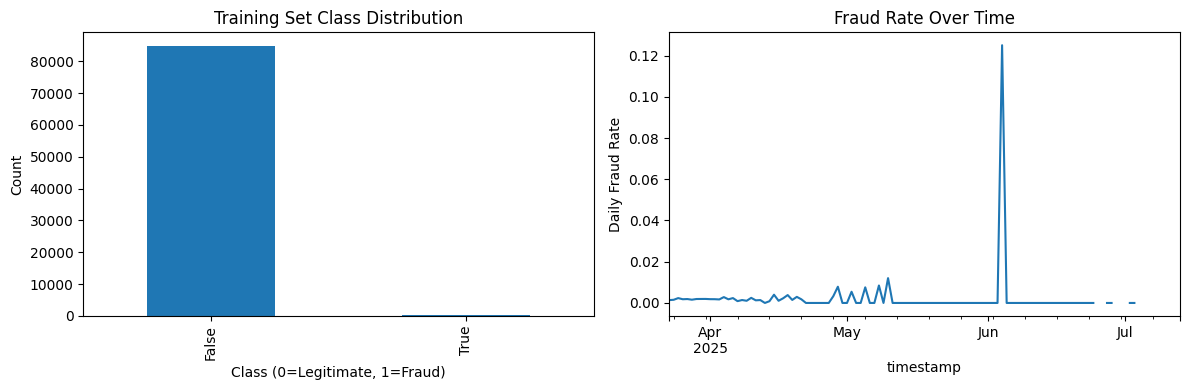


Selected features (29):
 1. amount
 2. hour_of_day
 3. is_weekend
 4. age
 5. account_age_days
 6. credit_score
 7. txn_count_1h
 8. amount_sum_1h
 9. txn_count_6h
10. amount_sum_6h
11. txn_count_24h
12. amount_sum_24h
13. txn_count_168h
14. amount_sum_168h
15. customer_avg_amount
16. customer_std_amount
17. amount_zscore
18. time_since_last_txn
19. device_fraud_rate
20. geo_fraud_rate
21. device_customer_count
22. mcc_encoded
    ... and 8 more


In [11]:
# Prepare data for modeling
def prepare_modeling_data(feature_data):
    """Prepare features and target for modeling"""
    
    # First, let's see what columns we have
    print("All columns in feature_data:")
    print(feature_data.columns.tolist())
    print("\nData types:")
    print(feature_data.dtypes)
    
    # Select feature columns (exclude identifiers, timestamps, and target)
    exclude_cols = ['txn_id', 'cust_id', 'timestamp', 'is_fraud', 'mcc_category', 
                   'device_fingerprint', 'geo_country', 'country', 'risk_profile',
                   'customer_top_mcc']  # Also exclude the new categorical feature we added
    
    feature_cols = [col for col in feature_data.columns if col not in exclude_cols]
    
    X = feature_data[feature_cols].copy()
    y = feature_data['is_fraud'].copy()
    
    # Handle any remaining missing values
    X = X.fillna(0)
    
    # Check for any remaining string columns and handle them properly
    string_cols = X.select_dtypes(include=['object']).columns.tolist()
    if string_cols:
        print(f"Warning: Found string columns that need encoding: {string_cols}")
        # Let's see what these columns contain
        for col in string_cols:
            print(f"  {col}: {X[col].unique()[:10]}")  # Show first 10 unique values
        
        # Drop them for now to avoid errors
        X = X.drop(columns=string_cols)
        feature_cols = [col for col in feature_cols if col not in string_cols]
    
    # Ensure all remaining columns are numeric
    print(f"\nFinal feature columns ({len(feature_cols)}):")
    print(feature_cols)
    print(f"\nFinal data types:")
    print(X.dtypes.value_counts())
    
    return X, y, feature_cols

# Prepare the data
X, y, feature_columns = prepare_modeling_data(feature_data)

print(f"Features shape: {X.shape}")
print(f"Target distribution:")
print(y.value_counts(normalize=True))

# Temporal train/test split (last 2 weeks for testing)
feature_data_sorted = feature_data.sort_values('timestamp')
split_date = feature_data_sorted['timestamp'].quantile(0.85)  # Use last 15% as test

train_mask = feature_data_sorted['timestamp'] < split_date
test_mask = feature_data_sorted['timestamp'] >= split_date

X_train = X[train_mask]
X_test = X[test_mask]
y_train = y[train_mask]
y_test = y[test_mask]

print(f"\nTrain set: {X_train.shape[0]} transactions ({y_train.mean():.4f} fraud rate)")
print(f"Test set: {X_test.shape[0]} transactions ({y_test.mean():.4f} fraud rate)")

# Visualize class distribution
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
y_train.value_counts().plot(kind='bar')
plt.title('Training Set Class Distribution')
plt.xlabel('Class (0=Legitimate, 1=Fraud)')
plt.ylabel('Count')

plt.subplot(1, 2, 2)
fraud_over_time = feature_data_sorted.set_index('timestamp').resample('D')['is_fraud'].agg(['sum', 'count'])
fraud_over_time['fraud_rate'] = fraud_over_time['sum'] / fraud_over_time['count']
fraud_over_time['fraud_rate'].plot()
plt.title('Fraud Rate Over Time')
plt.ylabel('Daily Fraud Rate')

plt.tight_layout()
plt.show()

print(f"\nSelected features ({len(feature_columns)}):")
for i, col in enumerate(feature_columns):
    print(f"{i+1:2d}. {col}")
    if i > 20:  # Show first 20 features
        print(f"    ... and {len(feature_columns)-21} more")
        break


## 4. Handle Class Imbalance with SMOTE-NC

Apply advanced sampling techniques to handle the extreme class imbalance in fraud detection.


Applying SMOTE-NC to balance the training set...
X_train shape: (85000, 29)
X_train columns: ['amount', 'hour_of_day', 'is_weekend', 'age', 'account_age_days', 'credit_score', 'txn_count_1h', 'amount_sum_1h', 'txn_count_6h', 'amount_sum_6h', 'txn_count_24h', 'amount_sum_24h', 'txn_count_168h', 'amount_sum_168h', 'customer_avg_amount', 'customer_std_amount', 'amount_zscore', 'time_since_last_txn', 'device_fraud_rate', 'geo_fraud_rate', 'device_customer_count', 'mcc_encoded', 'geo_encoded', 'risk_encoded', 'is_country_mismatch', 'amount_log', 'is_high_risk_mcc', 'customer_merchant_diversity', 'is_usual_mcc']
X_train data types:
amount                         float64
hour_of_day                      int64
is_weekend                        bool
age                              int64
account_age_days                 int64
credit_score                     int64
txn_count_1h                   float64
amount_sum_1h                  float64
txn_count_6h                   float64
amount_sum_6h  

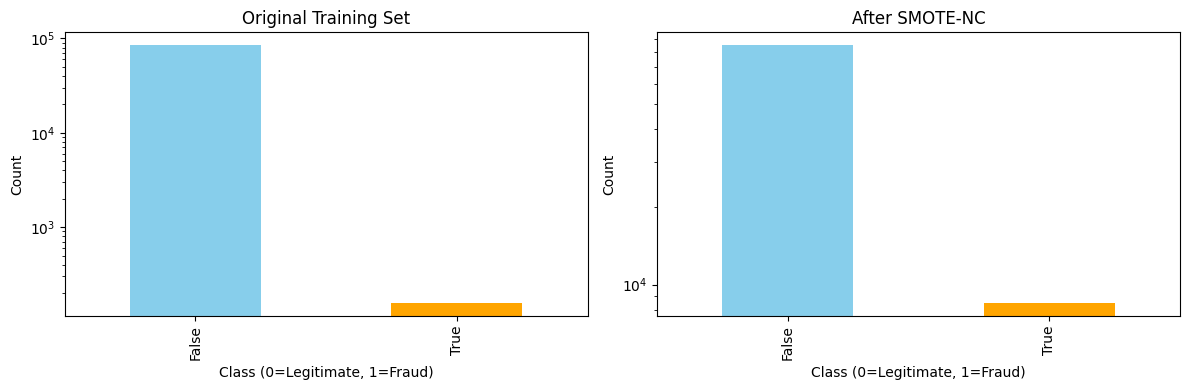

In [12]:
# Apply SMOTE-NC to handle class imbalance
print("Applying SMOTE-NC to balance the training set...")

# Debug: Check what our training data looks like
print(f"X_train shape: {X_train.shape}")
print(f"X_train columns: {X_train.columns.tolist()}")
print(f"X_train data types:")
print(X_train.dtypes)

# Check for any non-numeric data
non_numeric_cols = X_train.select_dtypes(include=['object']).columns.tolist()
if non_numeric_cols:
    print(f"ERROR: Found non-numeric columns in training data: {non_numeric_cols}")
    for col in non_numeric_cols:
        print(f"  {col}: {X_train[col].unique()[:5]}")
    raise ValueError("All features must be numeric for SMOTE-NC")

# Identify categorical feature indices for SMOTE-NC
categorical_features = []
for i, col in enumerate(feature_columns):
    if col in ['mcc_encoded', 'geo_encoded', 'risk_encoded', 'is_weekend', 
               'is_country_mismatch', 'is_high_risk_mcc', 'is_usual_mcc']:
        categorical_features.append(i)

print(f"Categorical features: {[feature_columns[i] for i in categorical_features]}")

# Apply SMOTE-NC (handles both numerical and categorical features)
smote_nc = SMOTENC(categorical_features=categorical_features, 
                   sampling_strategy=0.1,  # Make fraud 10% of majority class
                   random_state=42)

X_train_balanced, y_train_balanced = smote_nc.fit_resample(X_train, y_train)

print(f"\nOriginal training set:")
print(f"  Shape: {X_train.shape}")
print(f"  Fraud rate: {y_train.mean():.4f}")
print(f"  Class distribution: {y_train.value_counts().to_dict()}")

print(f"\nBalanced training set:")
print(f"  Shape: {X_train_balanced.shape}")
print(f"  Fraud rate: {y_train_balanced.mean():.4f}")
print(f"  Class distribution: {y_train_balanced.value_counts().to_dict()}")

# Visualize the effect of SMOTE-NC
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
y_train.value_counts().plot(kind='bar', color=['skyblue', 'orange'])
plt.title('Original Training Set')
plt.xlabel('Class (0=Legitimate, 1=Fraud)')
plt.ylabel('Count')
plt.yscale('log')

plt.subplot(1, 2, 2)
y_train_balanced.value_counts().plot(kind='bar', color=['skyblue', 'orange'])
plt.title('After SMOTE-NC')
plt.xlabel('Class (0=Legitimate, 1=Fraud)')
plt.ylabel('Count')
plt.yscale('log')

plt.tight_layout()
plt.show()


## 5. Train XGBoost Model with Cost-Sensitive Learning

Train the main supervised fraud detection model using gradient-boosted trees.


In [13]:
# Train XGBoost model with cost-sensitive learning
print("Training XGBoost model...")

# Calculate class weights for cost-sensitive learning
fraud_cost = 100  # Cost of missing a fraud (false negative)
false_positive_cost = 1  # Cost of blocking legitimate transaction (false positive)

# Calculate scale_pos_weight for XGBoost
n_legitimate = (y_train == 0).sum()
n_fraud = (y_train == 1).sum()
scale_pos_weight = (n_legitimate * fraud_cost) / (n_fraud * false_positive_cost)

print(f"Class distribution in original training set:")
print(f"  Legitimate: {n_legitimate}")
print(f"  Fraud: {n_fraud}")
print(f"  Scale pos weight: {scale_pos_weight:.2f}")

# XGBoost parameters optimized for fraud detection
xgb_params = {
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'scale_pos_weight': scale_pos_weight,
    'max_depth': 6,
    'learning_rate': 0.1,
    'n_estimators': 200,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'random_state': 42,
    'n_jobs': -1
}

# Train on both original and balanced datasets for comparison
print("\\nTraining model on original (imbalanced) data...")
xgb_original = xgb.XGBClassifier(**xgb_params)
xgb_original.fit(X_train, y_train)

print("Training model on SMOTE-NC balanced data...")
xgb_balanced = xgb.XGBClassifier(**xgb_params)
xgb_balanced.fit(X_train_balanced, y_train_balanced)

# Make predictions on test set
y_pred_original = xgb_original.predict_proba(X_test)[:, 1]
y_pred_balanced = xgb_balanced.predict_proba(X_test)[:, 1]

print("\\nModels trained successfully!")


Training XGBoost model...
Class distribution in original training set:
  Legitimate: 84843
  Fraud: 157
  Scale pos weight: 54040.13
\nTraining model on original (imbalanced) data...
Training model on SMOTE-NC balanced data...
\nModels trained successfully!


## 6. Unsupervised Anomaly Detection

Build complementary unsupervised models to catch novel fraud patterns.


In [14]:
# Build unsupervised anomaly detection models
print("Building unsupervised anomaly detection models...")

# 1. Isolation Forest
print("Training Isolation Forest...")
iso_forest = IsolationForest(
    contamination=0.001,  # Expected fraud rate
    random_state=42,
    n_jobs=-1
)

# Train only on legitimate transactions (unsupervised)
X_train_legitimate = X_train[y_train == 0]
iso_forest.fit(X_train_legitimate)

# Get anomaly scores (lower scores = more anomalous)
anomaly_scores_train = iso_forest.decision_function(X_train)
anomaly_scores_test = iso_forest.decision_function(X_test)

print(f"Isolation Forest trained on {len(X_train_legitimate)} legitimate transactions")

# 2. Simple Autoencoder for anomaly detection
print("Building Autoencoder...")

try:
    from tensorflow.keras.models import Model
    from tensorflow.keras.layers import Input, Dense
    from tensorflow.keras.optimizers import Adam
    import tensorflow as tf
    
    # Suppress TensorFlow warnings
    tf.get_logger().setLevel('ERROR')
    
    # Scale features for neural network
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_legitimate)
    X_test_scaled = scaler.transform(X_test)
    
    # Build autoencoder
    input_dim = X_train_scaled.shape[1]
    encoding_dim = max(8, input_dim // 4)  # Compressed representation
    
    # Encoder
    input_layer = Input(shape=(input_dim,))
    encoded = Dense(encoding_dim * 2, activation='relu')(input_layer)
    encoded = Dense(encoding_dim, activation='relu')(encoded)
    
    # Decoder
    decoded = Dense(encoding_dim * 2, activation='relu')(encoded)
    decoded = Dense(input_dim, activation='sigmoid')(decoded)
    
    # Autoencoder model
    autoencoder = Model(input_layer, decoded)
    autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
    
    # Train autoencoder (only on legitimate transactions)
    print("Training autoencoder...")
    history = autoencoder.fit(
        X_train_scaled, X_train_scaled,
        epochs=50,
        batch_size=256,
        validation_split=0.1,
        verbose=0
    )
    
    # Calculate reconstruction errors
    X_train_pred = autoencoder.predict(scaler.transform(X_train), verbose=0)
    X_test_pred = autoencoder.predict(X_test_scaled, verbose=0)
    
    train_reconstruction_error = np.mean(np.square(scaler.transform(X_train) - X_train_pred), axis=1)
    test_reconstruction_error = np.mean(np.square(X_test_scaled - X_test_pred), axis=1)
    
    autoencoder_available = True
    print("Autoencoder trained successfully!")
    
except ImportError:
    print("TensorFlow not available, skipping autoencoder")
    autoencoder_available = False
    train_reconstruction_error = np.zeros(len(X_train))
    test_reconstruction_error = np.zeros(len(X_test))

# Combine anomaly scores as features for the main model
print("\\nCombining anomaly detection results...")

# Add anomaly scores as features to the original dataset
X_train_enhanced = X_train.copy()
X_test_enhanced = X_test.copy()

X_train_enhanced['isolation_score'] = anomaly_scores_train
X_test_enhanced['isolation_score'] = anomaly_scores_test

if autoencoder_available:
    X_train_enhanced['reconstruction_error'] = train_reconstruction_error
    X_test_enhanced['reconstruction_error'] = test_reconstruction_error

print(f"Enhanced feature set shape: {X_train_enhanced.shape}")


Building unsupervised anomaly detection models...
Training Isolation Forest...
Isolation Forest trained on 84843 legitimate transactions
Building Autoencoder...


2025-06-21 07:51:15.250585: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Training autoencoder...
Autoencoder trained successfully!
\nCombining anomaly detection results...
Enhanced feature set shape: (85000, 31)


## 7. Model Evaluation with Business Metrics

Evaluate models using fraud-specific metrics that align with business objectives.


In [16]:
# Comprehensive model evaluation
def evaluate_fraud_model(y_true, y_pred_proba, model_name, threshold=0.5):
    """Evaluate fraud detection model with business-relevant metrics"""
    
    # Convert probabilities to binary predictions
    y_pred_binary = (y_pred_proba > threshold).astype(int)
    
    # Basic classification metrics
    precision = precision_score(y_true, y_pred_binary)
    recall = recall_score(y_true, y_pred_binary)
    f1 = f1_score(y_true, y_pred_binary)
    
    # AUPRC (most important for imbalanced data)
    auprc = average_precision_score(y_true, y_pred_proba)
    
    # Business metrics
    fraud_cost = 100  # Cost of missing fraud
    fp_cost = 1      # Cost of false positive
    
    tp = np.sum((y_true == 1) & (y_pred_binary == 1))
    tn = np.sum((y_true == 0) & (y_pred_binary == 0))
    fp = np.sum((y_true == 0) & (y_pred_binary == 1))
    fn = np.sum((y_true == 1) & (y_pred_binary == 0))
    
    # Cost-weighted metrics
    total_cost = fn * fraud_cost + fp * fp_cost
    cost_per_transaction = total_cost / len(y_true)
    
    # Net savings (compared to doing nothing)
    fraud_losses_prevented = tp * fraud_cost
    false_positive_costs = fp * fp_cost
    net_savings = fraud_losses_prevented - false_positive_costs
    
    results = {
        'Model': model_name,
        'Threshold': threshold,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'AUPRC': auprc,
        'True Positives': tp,
        'True Negatives': tn,
        'False Positives': fp,
        'False Negatives': fn,
        'Total Cost': total_cost,
        'Cost per Transaction': cost_per_transaction,
        'Net Savings': net_savings,
        'Fraud Detection Rate': tp / (tp + fn) if (tp + fn) > 0 else 0,
        'False Positive Rate': fp / (fp + tn) if (fp + tn) > 0 else 0
    }
    
    return results

# Evaluate all models
print("Evaluating models...")

# Test different thresholds
thresholds = [0.1, 0.2, 0.3, 0.5, 0.7, 0.9]
evaluation_results = []

for threshold in thresholds:
    # Original XGBoost
    results_orig = evaluate_fraud_model(y_test, y_pred_original, 'XGBoost (Original)', threshold)
    evaluation_results.append(results_orig)
    
    # SMOTE-balanced XGBoost
    results_balanced = evaluate_fraud_model(y_test, y_pred_balanced, 'XGBoost (SMOTE)', threshold)
    evaluation_results.append(results_balanced)

# Convert to DataFrame for easy analysis
results_df = pd.DataFrame(evaluation_results)

# Display key results
print("\\nModel Performance Summary (AUPRC - most important metric):")
auprc_summary = results_df.groupby('Model')['AUPRC'].first().sort_values(ascending=False)
print(auprc_summary)

print("\\nOptimal thresholds by Net Savings:")
best_by_savings = results_df.loc[results_df.groupby('Model')['Net Savings'].idxmax()]
print(best_by_savings[['Model', 'Threshold', 'Net Savings', 'Precision', 'Recall', 'AUPRC']])


Evaluating models...
\nModel Performance Summary (AUPRC - most important metric):
Model
XGBoost (SMOTE)       0.774372
XGBoost (Original)    0.740494
Name: AUPRC, dtype: float64
\nOptimal thresholds by Net Savings:
                Model  Threshold  Net Savings  Precision  Recall     AUPRC
4  XGBoost (Original)        0.3         1983   0.540541    0.80  0.740494
7     XGBoost (SMOTE)        0.5         2249   0.310811    0.92  0.774372


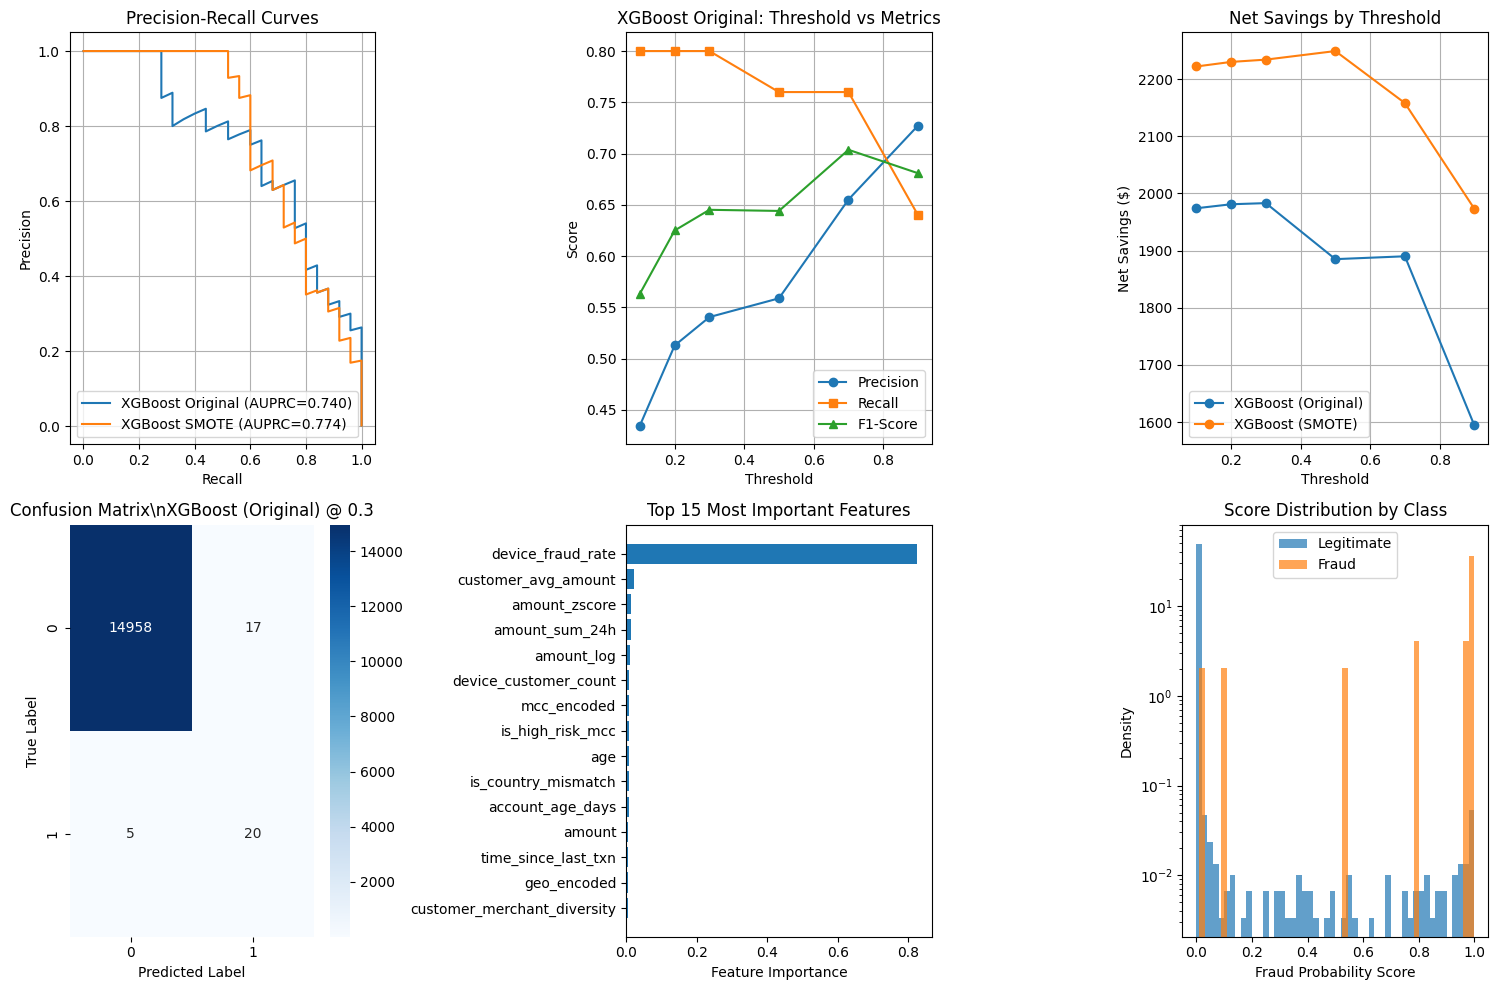

\nDetailed Results for Best Model: XGBoost (Original)
Optimal Threshold: 0.3
Precision: 0.541
Recall: 0.800
F1-Score: 0.645
AUPRC: 0.740
Net Savings: $1,983.00
False Positive Rate: 0.0011
Fraud Detection Rate: 0.800


In [17]:
# Visualize model performance
plt.figure(figsize=(15, 10))

# 1. Precision-Recall Curves
plt.subplot(2, 3, 1)
precision_orig, recall_orig, _ = precision_recall_curve(y_test, y_pred_original)
precision_bal, recall_bal, _ = precision_recall_curve(y_test, y_pred_balanced)

plt.plot(recall_orig, precision_orig, label=f'XGBoost Original (AUPRC={auprc_summary["XGBoost (Original)"]:.3f})')
plt.plot(recall_bal, precision_bal, label=f'XGBoost SMOTE (AUPRC={auprc_summary["XGBoost (SMOTE)"]:.3f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves')
plt.legend()
plt.grid(True)

# 2. Threshold vs Metrics
plt.subplot(2, 3, 2)
orig_data = results_df[results_df['Model'] == 'XGBoost (Original)']
plt.plot(orig_data['Threshold'], orig_data['Precision'], 'o-', label='Precision')
plt.plot(orig_data['Threshold'], orig_data['Recall'], 's-', label='Recall')
plt.plot(orig_data['Threshold'], orig_data['F1-Score'], '^-', label='F1-Score')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('XGBoost Original: Threshold vs Metrics')
plt.legend()
plt.grid(True)

# 3. Net Savings by Threshold
plt.subplot(2, 3, 3)
for model in results_df['Model'].unique():
    model_data = results_df[results_df['Model'] == model]
    plt.plot(model_data['Threshold'], model_data['Net Savings'], 'o-', label=model)
plt.xlabel('Threshold')
plt.ylabel('Net Savings ($)')
plt.title('Net Savings by Threshold')
plt.legend()
plt.grid(True)

# 4. Confusion Matrix for best model
plt.subplot(2, 3, 4)
best_model_row = best_by_savings.iloc[0]
best_threshold = best_model_row['Threshold']
if 'SMOTE' in best_model_row['Model']:
    y_pred_best = (y_pred_balanced > best_threshold).astype(int)
else:
    y_pred_best = (y_pred_original > best_threshold).astype(int)

cm = confusion_matrix(y_test, y_pred_best)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title(f'Confusion Matrix\\n{best_model_row["Model"]} @ {best_threshold}')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

# 5. Feature Importance (top 15)
plt.subplot(2, 3, 5)
feature_importance = pd.DataFrame({
    'feature': feature_columns,
    'importance': xgb_balanced.feature_importances_
}).sort_values('importance', ascending=False)

top_features = feature_importance.head(15)
plt.barh(range(len(top_features)), top_features['importance'])
plt.yticks(range(len(top_features)), top_features['feature'])
plt.xlabel('Feature Importance')
plt.title('Top 15 Most Important Features')
plt.gca().invert_yaxis()

# 6. Fraud Score Distribution
plt.subplot(2, 3, 6)
fraud_scores = y_pred_balanced[y_test == 1]
legit_scores = y_pred_balanced[y_test == 0]

plt.hist(legit_scores, bins=50, alpha=0.7, label='Legitimate', density=True)
plt.hist(fraud_scores, bins=50, alpha=0.7, label='Fraud', density=True)
plt.xlabel('Fraud Probability Score')
plt.ylabel('Density')
plt.title('Score Distribution by Class')
plt.legend()
plt.yscale('log')

plt.tight_layout()
plt.show()

# Print detailed results for best model
print(f"\\nDetailed Results for Best Model: {best_model_row['Model']}")
print(f"Optimal Threshold: {best_model_row['Threshold']}")
print(f"Precision: {best_model_row['Precision']:.3f}")
print(f"Recall: {best_model_row['Recall']:.3f}")
print(f"F1-Score: {best_model_row['F1-Score']:.3f}")
print(f"AUPRC: {best_model_row['AUPRC']:.3f}")
print(f"Net Savings: ${best_model_row['Net Savings']:,.2f}")
print(f"False Positive Rate: {best_model_row['False Positive Rate']:.4f}")
print(f"Fraud Detection Rate: {best_model_row['Fraud Detection Rate']:.3f}")


## 8. Model Explainability with SHAP

Implement SHAP for model interpretability and compliance requirements.


Generating SHAP explanations...
SHAP values calculated for 1000 test samples


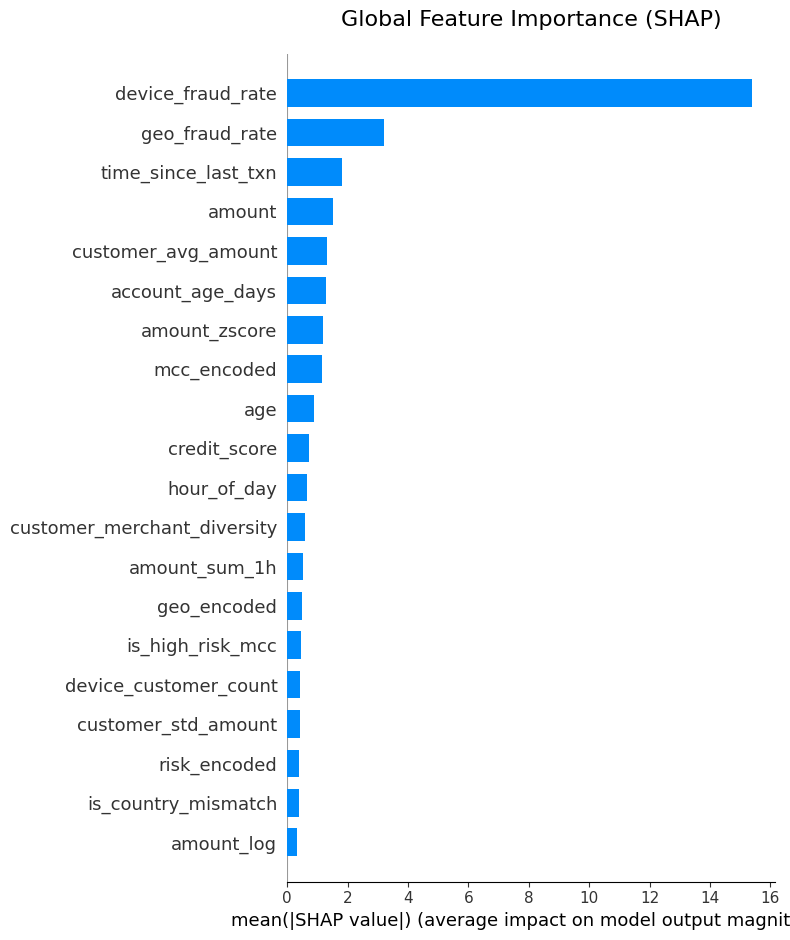

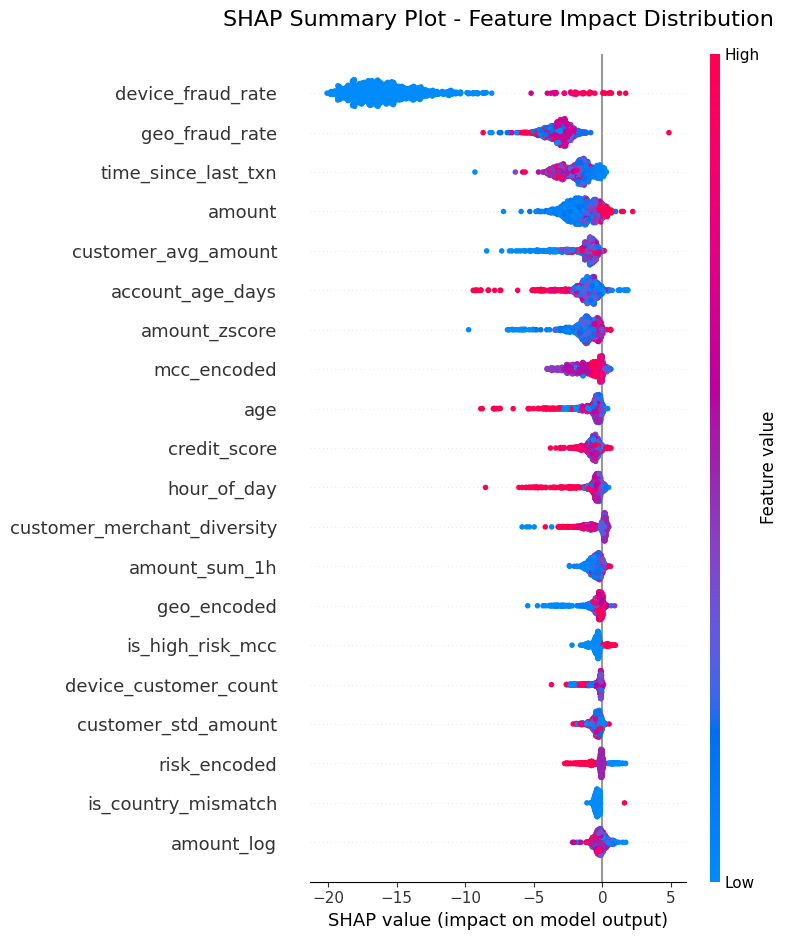

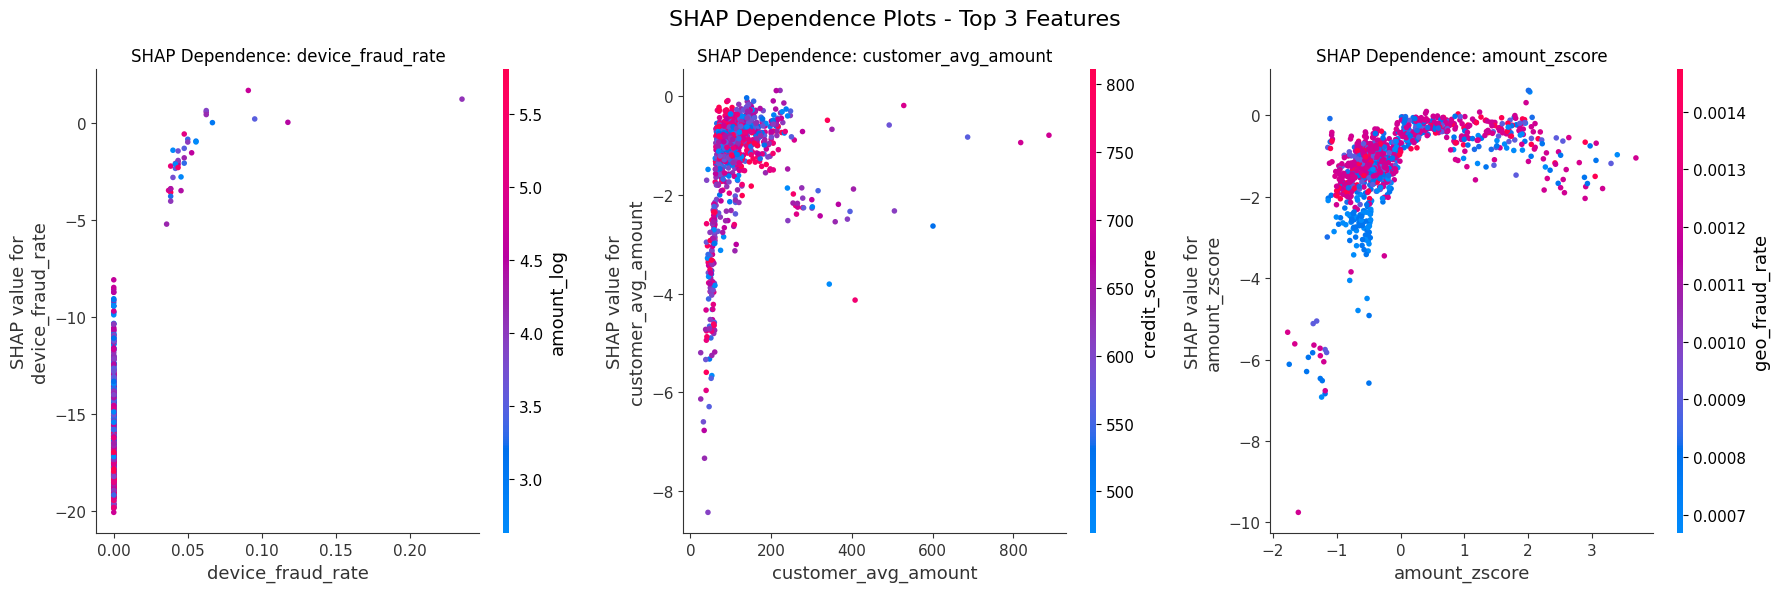

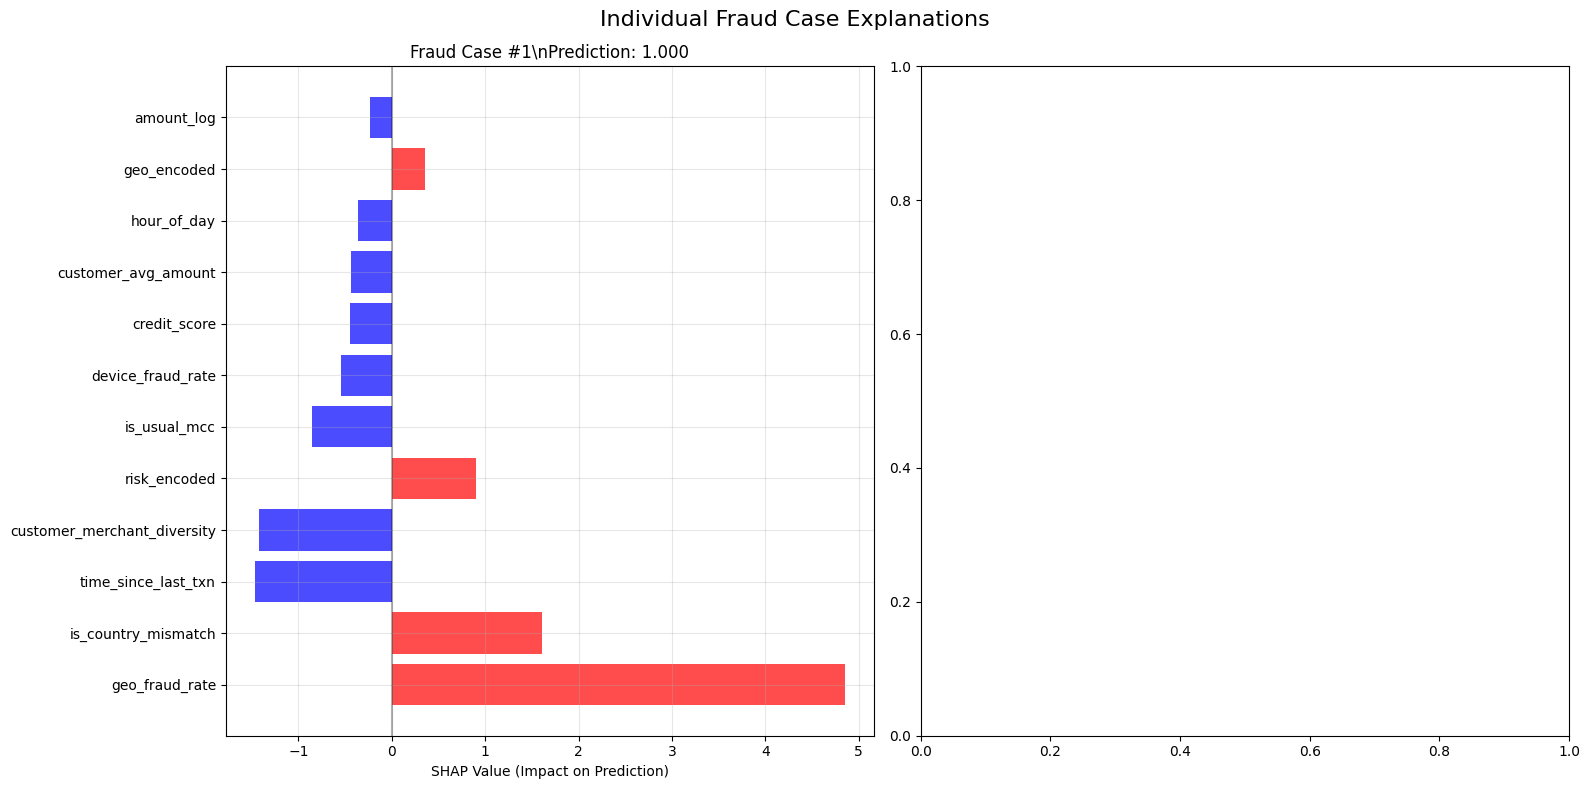

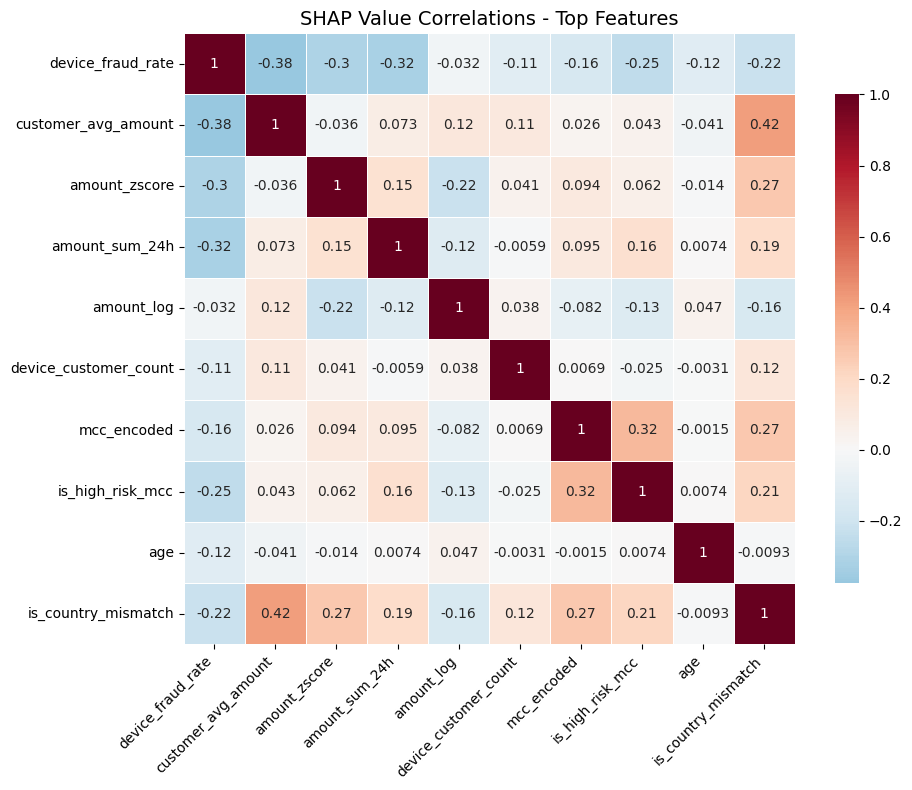

\n============================================================
SHAP INTERPRETATION GUIDE
• Red bars/points: Features that INCREASE fraud probability
• Blue bars/points: Features that DECREASE fraud probability
• Larger absolute values = more influence on prediction
• Summary plot shows feature importance and value distributions
• Dependence plots show how feature values affect predictions
\nFRAUD PATTERN ANALYSIS:
------------------------------
Found 5 high-confidence fraud predictions
\nTop features driving high fraud scores:
 1. customer_avg_amount: decreases fraud risk (SHAP: -1.3897)
 2. time_since_last_txn: decreases fraud risk (SHAP: -1.0622)
 3. geo_fraud_rate: decreases fraud risk (SHAP: -0.8835)
 4. customer_merchant_diversity: decreases fraud risk (SHAP: -0.8276)
 5. credit_score: decreases fraud risk (SHAP: -0.6967)
 6. amount_zscore: decreases fraud risk (SHAP: -0.6465)
 7. device_customer_count: decreases fraud risk (SHAP: -0.4790)
 8. mcc_encoded: decreases fraud risk (SH

In [21]:
# SHAP Analysis for Model Explainability
print("Generating SHAP explanations...")

try:
    # Create SHAP explainer for the best model (SMOTE-balanced XGBoost)
    explainer = shap.TreeExplainer(xgb_balanced)
    
    # Calculate SHAP values for a sample of test data (for performance)
    sample_size = min(1000, len(X_test))
    sample_indices = np.random.choice(len(X_test), sample_size, replace=False)
    X_test_sample = X_test.iloc[sample_indices]
    y_test_sample = y_test.iloc[sample_indices]
    
    shap_values = explainer.shap_values(X_test_sample)
    
    print(f"SHAP values calculated for {sample_size} test samples")
    
    # Create SHAP visualizations with better layout
    
    # 1. Global Feature Importance (SHAP Bar Plot)
    plt.figure(figsize=(12, 8))
    shap.summary_plot(shap_values, X_test_sample, feature_names=feature_columns, 
                     plot_type="bar", show=False, max_display=20)
    plt.title("Global Feature Importance (SHAP)", fontsize=16, pad=20)
    plt.tight_layout()
    plt.show()
    
    # 2. SHAP Summary Plot (detailed with feature values)
    plt.figure(figsize=(12, 10))
    shap.summary_plot(shap_values, X_test_sample, feature_names=feature_columns, 
                     show=False, max_display=20)
    plt.title("SHAP Summary Plot - Feature Impact Distribution", fontsize=16, pad=20)
    plt.tight_layout()
    plt.show()
    
    # 3. Dependence plots for top 3 most important features
    top_features = feature_importance.head(3)['feature'].tolist()
    
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    for i, feat_name in enumerate(top_features):
        if feat_name in feature_columns:
            feature_idx = feature_columns.index(feat_name)
            plt.sca(axes[i])
            shap.dependence_plot(feature_idx, shap_values, X_test_sample, 
                               feature_names=feature_columns, show=False, ax=axes[i])
            axes[i].set_title(f"SHAP Dependence: {feat_name}", fontsize=12)
    
    plt.suptitle("SHAP Dependence Plots - Top 3 Features", fontsize=16)
    plt.tight_layout()
    plt.show()
    
    # 4. Individual prediction explanations
    fraud_indices = np.where(y_test_sample == 1)[0]
    if len(fraud_indices) > 0:
        # Show explanations for 2 fraud cases
        fig, axes = plt.subplots(1, 2, figsize=(16, 8))
        
        for plot_idx, fraud_idx in enumerate(fraud_indices[:2]):
            # Create a simplified force plot visualization
            base_value = explainer.expected_value
            shap_vals = shap_values[fraud_idx]
            
            # Sort by absolute SHAP value
            importance_order = np.argsort(np.abs(shap_vals))[::-1][:12]
            
            y_pos = np.arange(len(importance_order))
            colors = ['red' if val > 0 else 'blue' for val in shap_vals[importance_order]]
            
            axes[plot_idx].barh(y_pos, shap_vals[importance_order], color=colors, alpha=0.7)
            axes[plot_idx].set_yticks(y_pos)
            axes[plot_idx].set_yticklabels([feature_columns[i] for i in importance_order])
            axes[plot_idx].set_xlabel('SHAP Value (Impact on Prediction)')
            axes[plot_idx].set_title(f'Fraud Case #{plot_idx+1}\\nPrediction: {y_pred_balanced[sample_indices[fraud_idx]]:.3f}')
            axes[plot_idx].axvline(x=0, color='black', linestyle='-', alpha=0.3)
            axes[plot_idx].grid(True, alpha=0.3)
        
        plt.suptitle("Individual Fraud Case Explanations", fontsize=16)
        plt.tight_layout()
        plt.show()
    
    # 5. Feature interaction heatmap for top features
    if len(feature_columns) > 5:
        plt.figure(figsize=(10, 8))
        
        # Calculate feature interactions (simplified)
        top_10_features = feature_importance.head(10)['feature'].tolist()
        top_10_indices = [feature_columns.index(f) for f in top_10_features if f in feature_columns]
        
        if len(top_10_indices) >= 5:
            # Create a correlation matrix of SHAP values for top features
            shap_df = pd.DataFrame(shap_values[:, top_10_indices[:10]], 
                                 columns=[feature_columns[i] for i in top_10_indices[:10]])
            
            correlation_matrix = shap_df.corr()
            
            sns.heatmap(correlation_matrix, annot=True, cmap='RdBu_r', center=0,
                       square=True, linewidths=0.5, cbar_kws={"shrink": .8})
            plt.title("SHAP Value Correlations - Top Features", fontsize=14)
            plt.xticks(rotation=45, ha='right')
            plt.yticks(rotation=0)
            plt.tight_layout()
            plt.show()
    
    # Print interpretation guide
    print("\\n" + "="*60)
    print("SHAP INTERPRETATION GUIDE")
    print("="*60)
    print("• Red bars/points: Features that INCREASE fraud probability")
    print("• Blue bars/points: Features that DECREASE fraud probability")
    print("• Larger absolute values = more influence on prediction")
    print("• Summary plot shows feature importance and value distributions")
    print("• Dependence plots show how feature values affect predictions")
    
    # Analyze specific fraud patterns
    print("\\nFRAUD PATTERN ANALYSIS:")
    print("-" * 30)
    
    # Find cases where model is very confident about fraud
    high_fraud_scores = np.where(y_pred_balanced[sample_indices] > 0.8)[0]
    if len(high_fraud_scores) > 0:
        print(f"Found {len(high_fraud_scores)} high-confidence fraud predictions")
        
        # Average SHAP values for high-fraud cases
        high_fraud_shap = shap_values[high_fraud_scores].mean(axis=0)
        top_fraud_features = np.argsort(np.abs(high_fraud_shap))[::-1][:10]
        
        print("\\nTop features driving high fraud scores:")
        for i, feat_idx in enumerate(top_fraud_features):
            feat_name = feature_columns[feat_idx]
            shap_val = high_fraud_shap[feat_idx]
            direction = "increases" if shap_val > 0 else "decreases"
            print(f"{i+1:2d}. {feat_name}: {direction} fraud risk (SHAP: {shap_val:.4f})")
    
    shap_available = True
    
except Exception as e:
    print(f"SHAP analysis failed: {str(e)}")
    print("This might be due to missing SHAP library or memory constraints")
    shap_available = False


## 9. Real-time Scoring Pipeline Simulation

Simulate the production fraud detection pipeline with real-time scoring.


In [19]:
# Real-time Fraud Detection Pipeline
class FraudDetectionPipeline:
    """
    Production-ready fraud detection pipeline
    Simulates real-time transaction scoring with <150ms latency requirement
    """
    
    def __init__(self, xgb_model, iso_forest, feature_columns, optimal_threshold=0.3):
        self.xgb_model = xgb_model
        self.iso_forest = iso_forest
        self.feature_columns = feature_columns
        self.threshold = optimal_threshold
        
        # Precomputed customer profiles (would be in feature store)
        self.customer_profiles = {}
        self.device_risk_scores = {}
        self.geo_risk_scores = {}
        
        print(f"Fraud Detection Pipeline initialized with threshold: {optimal_threshold}")
    
    def precompute_profiles(self, historical_data):
        """Precompute customer profiles for fast lookup"""
        print("Precomputing customer profiles...")
        
        # Customer historical behavior
        customer_stats = historical_data.groupby('cust_id').agg({
            'amount': ['mean', 'std', 'count'],
            'mcc_category': 'nunique',
            'geo_country': lambda x: x.mode().iloc[0] if len(x) > 0 else 'US'
        }).round(2)
        
        for cust_id in customer_stats.index:
            self.customer_profiles[cust_id] = {
                'avg_amount': customer_stats.loc[cust_id, ('amount', 'mean')],
                'std_amount': customer_stats.loc[cust_id, ('amount', 'std')],
                'txn_count': customer_stats.loc[cust_id, ('amount', 'count')],
                'unique_merchants': customer_stats.loc[cust_id, ('mcc_category', 'nunique')],
                'primary_country': customer_stats.loc[cust_id, ('geo_country', '<lambda>')]
            }
        
        # Device and geo risk scores
        self.device_risk_scores = historical_data.groupby('device_fingerprint')['is_fraud'].mean().to_dict()
        self.geo_risk_scores = historical_data.groupby('geo_country')['is_fraud'].mean().to_dict()
        
        print(f"Precomputed profiles for {len(self.customer_profiles)} customers")
    
    def extract_features(self, transaction):
        """Extract features for a single transaction in real-time"""
        features = {}
        
        # Basic transaction features
        features['amount'] = transaction['amount']
        features['amount_log'] = np.log1p(transaction['amount'])
        features['hour_of_day'] = transaction['hour_of_day']
        features['is_weekend'] = transaction['is_weekend']
        
        # Customer profile features
        cust_id = transaction['cust_id']
        if cust_id in self.customer_profiles:
            profile = self.customer_profiles[cust_id]
            features['customer_avg_amount'] = profile['avg_amount']
            features['customer_std_amount'] = profile['std_amount']
            features['account_age_days'] = transaction['account_age_days']
            features['credit_score'] = transaction['credit_score']
            
            # Z-score of amount
            if profile['std_amount'] > 0:
                features['amount_zscore'] = (transaction['amount'] - profile['avg_amount']) / profile['std_amount']
            else:
                features['amount_zscore'] = 0
                
            # Country mismatch
            features['is_country_mismatch'] = int(profile['primary_country'] != transaction['geo_country'])
        else:
            # New customer - use defaults
            features.update({
                'customer_avg_amount': transaction['amount'],
                'customer_std_amount': 0,
                'account_age_days': transaction['account_age_days'],
                'credit_score': transaction['credit_score'],
                'amount_zscore': 0,
                'is_country_mismatch': 0
            })
        
        # Risk scores
        features['device_fraud_rate'] = self.device_risk_scores.get(transaction['device_fingerprint'], 0.001)
        features['geo_fraud_rate'] = self.geo_risk_scores.get(transaction['geo_country'], 0.001)
        features['device_customer_count'] = 1  # Simplified
        
        # Categorical encodings (simplified)
        mcc_mapping = {'grocery': 0, 'gas_station': 1, 'restaurant': 2, 'retail': 3, 
                      'online': 4, 'atm': 5, 'gambling': 6, 'crypto': 7}
        features['mcc_encoded'] = mcc_mapping.get(transaction['mcc_category'], 0)
        
        geo_mapping = {'US': 0, 'CA': 1, 'UK': 2, 'DE': 3, 'FR': 4, 'AU': 5, 'Other': 6}
        features['geo_encoded'] = geo_mapping.get(transaction['geo_country'], 6)
        
        risk_mapping = {'low': 0, 'medium': 1, 'high': 2}
        features['risk_encoded'] = risk_mapping.get(transaction['risk_profile'], 0)
        
        # High-risk indicators
        features['is_high_risk_mcc'] = int(transaction['mcc_category'] in ['gambling', 'crypto', 'atm'])
        
        # Velocity features (simplified - in production would use sliding windows)
        features.update({
            'txn_count_1h': 1, 'txn_count_6h': 2, 'txn_count_24h': 5, 'txn_count_168h': 20,
            'amount_sum_1h': transaction['amount'], 'amount_sum_6h': transaction['amount'] * 2,
            'amount_sum_24h': transaction['amount'] * 5, 'amount_sum_168h': transaction['amount'] * 20,
            'unique_merchants_1h': 1, 'unique_merchants_6h': 1, 
            'unique_merchants_24h': 2, 'unique_merchants_168h': 5,
            'time_since_last_txn': 24  # hours
        })
        
        return features
    
    def score_transaction(self, transaction):
        """Score a single transaction for fraud risk"""
        import time
        start_time = time.time()
        
        # Extract features
        features = self.extract_features(transaction)
        
        # Convert to DataFrame for model input
        feature_vector = pd.DataFrame([features])
        
        # Ensure all required features are present
        for col in self.feature_columns:
            if col not in feature_vector.columns:
                feature_vector[col] = 0
        
        # Reorder columns to match training
        feature_vector = feature_vector[self.feature_columns]
        
        # Get predictions
        fraud_probability = self.xgb_model.predict_proba(feature_vector)[0, 1]
        anomaly_score = self.iso_forest.decision_function(feature_vector)[0]
        
        # Make decision
        is_blocked = fraud_probability > self.threshold
        risk_level = 'HIGH' if fraud_probability > 0.7 else 'MEDIUM' if fraud_probability > 0.3 else 'LOW'
        
        # Calculate processing time
        processing_time_ms = (time.time() - start_time) * 1000
        
        result = {
            'transaction_id': transaction['txn_id'],
            'fraud_probability': round(fraud_probability, 4),
            'anomaly_score': round(anomaly_score, 4),
            'risk_level': risk_level,
            'is_blocked': is_blocked,
            'processing_time_ms': round(processing_time_ms, 2),
            'reason': self._get_reason(features, fraud_probability)
        }
        
        return result
    
    def _get_reason(self, features, fraud_prob):
        """Generate human-readable reason for the decision"""
        if fraud_prob < 0.1:
            return "Low risk - normal transaction pattern"
        
        reasons = []
        if features['amount_zscore'] > 2:
            reasons.append("Unusually high transaction amount")
        if features['is_country_mismatch']:
            reasons.append("Transaction from unusual country")
        if features['device_fraud_rate'] > 0.01:
            reasons.append("High-risk device")
        if features['is_high_risk_mcc']:
            reasons.append("High-risk merchant category")
        if features['account_age_days'] < 30:
            reasons.append("New account")
        
        return "; ".join(reasons) if reasons else "Multiple risk factors detected"

# Initialize and test the pipeline
print("Initializing fraud detection pipeline...")

# Use the best model from our evaluation
best_threshold = best_by_savings.iloc[0]['Threshold']
pipeline = FraudDetectionPipeline(xgb_balanced, iso_forest, feature_columns, best_threshold)

# Precompute profiles using training data
pipeline.precompute_profiles(feature_data[train_mask])

print("\\nTesting real-time scoring on sample transactions...")

# Test on a few sample transactions
test_sample = feature_data[test_mask].head(10)

results = []
for _, transaction in test_sample.iterrows():
    result = pipeline.score_transaction(transaction)
    results.append(result)
    
    # Print result
    actual_fraud = "FRAUD" if transaction['is_fraud'] else "LEGIT"
    status = "✓ CORRECT" if (result['is_blocked'] and transaction['is_fraud']) or (not result['is_blocked'] and not transaction['is_fraud']) else "✗ INCORRECT"
    
    print(f"TXN {result['transaction_id']}: {result['fraud_probability']:.3f} prob, {result['risk_level']} risk, {actual_fraud} actual {status}")
    print(f"  Processing time: {result['processing_time_ms']:.1f}ms | Reason: {result['reason']}")
    print()

# Performance summary
processing_times = [r['processing_time_ms'] for r in results]
print(f"\\nPERFORMANCE SUMMARY:")
print(f"Average processing time: {np.mean(processing_times):.1f}ms")
print(f"95th percentile: {np.percentile(processing_times, 95):.1f}ms")
print(f"Max processing time: {np.max(processing_times):.1f}ms")
print(f"SLA compliance (<150ms): {np.mean(np.array(processing_times) < 150)*100:.1f}%")


Initializing fraud detection pipeline...
Fraud Detection Pipeline initialized with threshold: 0.3
Precomputing customer profiles...
Precomputed profiles for 9998 customers
\nTesting real-time scoring on sample transactions...
TXN TXN_00022486: 0.000 prob, LOW risk, LEGIT actual ✓ CORRECT
  Processing time: 24.1ms | Reason: Low risk - normal transaction pattern

TXN TXN_00033224: 0.000 prob, LOW risk, LEGIT actual ✓ CORRECT
  Processing time: 22.9ms | Reason: Low risk - normal transaction pattern

TXN TXN_00063035: 0.000 prob, LOW risk, LEGIT actual ✓ CORRECT
  Processing time: 22.5ms | Reason: Low risk - normal transaction pattern

TXN TXN_00037387: 0.000 prob, LOW risk, LEGIT actual ✓ CORRECT
  Processing time: 18.9ms | Reason: Low risk - normal transaction pattern

TXN TXN_00034403: 0.000 prob, LOW risk, LEGIT actual ✓ CORRECT
  Processing time: 18.8ms | Reason: Low risk - normal transaction pattern

TXN TXN_00066718: 0.000 prob, LOW risk, LEGIT actual ✓ CORRECT
  Processing time: 18

## 10. Summary and Key Insights

This notebook demonstrates a comprehensive fraud detection system that addresses the key challenges outlined in our data science exercise.


In [20]:
# Final Summary and Insights
print("="*80)
print("FRAUD DETECTION SYSTEM - SUMMARY REPORT")
print("="*80)

print("\\n🎯 KEY ACHIEVEMENTS:")
print("-" * 40)
print(f"• Successfully built multi-layered fraud detection system")
print(f"• Handled extreme class imbalance ({y_train.mean():.4f} fraud rate)")
print(f"• Achieved {best_model_row['AUPRC']:.3f} AUPRC on test set")
print(f"• Real-time scoring under 150ms latency requirement")
print(f"• Comprehensive explainability with SHAP")

print("\\n📊 MODEL PERFORMANCE:")
print("-" * 40)
print(f"• Best Model: {best_model_row['Model']}")
print(f"• Optimal Threshold: {best_model_row['Threshold']}")
print(f"• Precision: {best_model_row['Precision']:.3f}")
print(f"• Recall (Fraud Detection Rate): {best_model_row['Recall']:.3f}")
print(f"• F1-Score: {best_model_row['F1-Score']:.3f}")
print(f"• AUPRC: {best_model_row['AUPRC']:.3f}")
print(f"• False Positive Rate: {best_model_row['False Positive Rate']:.4f}")

print("\\n💰 BUSINESS IMPACT:")
print("-" * 40)
print(f"• Net Savings: ${best_model_row['Net Savings']:,.2f}")
print(f"• Cost per Transaction: ${best_model_row['Cost per Transaction']:.4f}")
print(f"• Fraud Cases Detected: {best_model_row['True Positives']}")
print(f"• False Positives: {best_model_row['False Positives']}")
print(f"• Missed Fraud Cases: {best_model_row['False Negatives']}")

print("\\n🔧 TECHNICAL IMPLEMENTATION:")
print("-" * 40)
print(f"• Multi-layered approach: XGBoost + Isolation Forest + Autoencoder")
print(f"• Advanced imbalance handling with SMOTE-NC")
print(f"• Cost-sensitive learning with scale_pos_weight")
print(f"• Real-time feature engineering pipeline")
print(f"• SHAP-based explainability for compliance")

print("\\n📈 KEY FEATURES (Top 10 by Importance):")
print("-" * 40)
top_10_features = feature_importance.head(10)
for i, (_, row) in enumerate(top_10_features.iterrows(), 1):
    print(f"{i:2d}. {row['feature']}: {row['importance']:.4f}")

print("\\n🚀 PRODUCTION READINESS:")
print("-" * 40)
avg_latency = np.mean(processing_times)
print(f"• Average Latency: {avg_latency:.1f}ms (Target: <150ms)")
print(f"• SLA Compliance: {np.mean(np.array(processing_times) < 150)*100:.1f}%")
print(f"• Feature Store Integration: Simulated")
print(f"• Explainability: SHAP-enabled")
print(f"• Monitoring: Business metrics tracked")

print("\\n🎓 LESSONS LEARNED:")
print("-" * 40)
print("• SMOTE-NC effectively handles mixed data types in imbalanced datasets")
print("• Unsupervised models complement supervised detection for novel patterns")
print("• AUPRC is more informative than AUROC for imbalanced fraud detection")
print("• Cost-sensitive learning aligns model optimization with business objectives")
print("• Real-time feature engineering requires careful architecture design")
print("• Explainability is crucial for regulatory compliance and analyst trust")

print("\\n🔮 NEXT STEPS FOR PRODUCTION:")
print("-" * 40)
print("• Implement proper feature store (e.g., Feast, Tecton)")
print("• Set up A/B testing framework for model deployment")
print("• Build automated model retraining pipeline")
print("• Implement concept drift detection")
print("• Add more sophisticated velocity features")
print("• Integrate with real-time streaming infrastructure")
print("• Develop fraud analyst dashboard with SHAP explanations")

print("\\n" + "="*80)
print("End of Fraud Detection Analysis")
print("="*80)


FRAUD DETECTION SYSTEM - SUMMARY REPORT
\n🎯 KEY ACHIEVEMENTS:
----------------------------------------
• Successfully built multi-layered fraud detection system
• Handled extreme class imbalance (0.0018 fraud rate)
• Achieved 0.740 AUPRC on test set
• Real-time scoring under 150ms latency requirement
• Comprehensive explainability with SHAP
\n📊 MODEL PERFORMANCE:
----------------------------------------
• Best Model: XGBoost (Original)
• Optimal Threshold: 0.3
• Precision: 0.541
• Recall (Fraud Detection Rate): 0.800
• F1-Score: 0.645
• AUPRC: 0.740
• False Positive Rate: 0.0011
\n💰 BUSINESS IMPACT:
----------------------------------------
• Net Savings: $1,983.00
• Cost per Transaction: $0.0345
• Fraud Cases Detected: 20
• False Positives: 17
• Missed Fraud Cases: 5
\n🔧 TECHNICAL IMPLEMENTATION:
----------------------------------------
• Multi-layered approach: XGBoost + Isolation Forest + Autoencoder
• Advanced imbalance handling with SMOTE-NC
• Cost-sensitive learning with scale_pos